In [ ]:
import pandas as pd
import numpy as np
import scipy as sp
import os
import random
import matplotlib.pyplot as plt
from time import time
import cv2

from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, roc_auc_score

import tensorflow as tf
import keras
from keras import layers
from keras import backend as K
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.utils.np_utils import to_categorical
from keras import models
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input

In [ ]:
def convert_to_image(pixels):
    pixels = np.array([int(i) for i in pixels.split()]).astype('float32')
    dst = cv2.resize(pixels.reshape(48,48, 1), dsize=(75, 75), interpolation=cv2.INTER_AREA)
    dst = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)
    return dst

def read_data(df, usage_type):

    X = df[ df['Usage'] == usage_type ]['pixels'].values
    y = to_categorical(df[ df['Usage'] == usage_type ]['emotion'].values)
    X = np.array([ convert_to_image(X[i]) for i in range(len(X)) ])

    return X, y

In [ ]:
df = pd.read_csv('data/fer2013.csv')

train_X, train_y = read_data(df, 'Training')
val_X, val_y = read_data(df, 'PublicTest')
test_X, test_y = read_data(df, 'PrivateTest')

train_X = keras.applications.resnet50.preprocess_input(train_X)
val_X = keras.applications.resnet50.preprocess_input(val_X)
test_X = keras.applications.resnet50.preprocess_input(test_X)

In [ ]:
print(train_X.shape, train_y.shape)
print(val_X.shape, val_y.shape)
print(test_X.shape, test_y.shape)

(28709, 75, 75, 3) (28709, 7)
(3589, 75, 75, 3) (3589, 7)
(3589, 75, 75, 3) (3589, 7)


In [ ]:
from IPython.display import clear_output

class LogCallback(keras.callbacks.Callback):

    def __init__(self):

        super().__init__()

    def on_epoch_end(self, epoch, logs=None):

        mepoch = epoch + 1

        clear_output()
        print(logs)


class EmotResNet(models.Model):

    def __init__(self, input_shape=(75, 75, 3)):

        x = layers.Input(shape=input_shape)
        base = keras.applications.resnet.ResNet50(include_top=True, weights = None, input_tensor=x, pooling=None, classes=7)

        super().__init__(x, base.output)

        self.compile(loss='categorical_crossentropy',
                     optimizer = keras.optimizers.Adamax(lr=0.002), metrics=['accuracy'])


def train(X_train, y_train, X_test, y_test, prefix='emot'):

    start_time = time()

    logCallback = LogCallback()
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
    mc = ModelCheckpoint('model/{}_{}.h5'.format(prefix,start_time), monitor='val_accuracy', mode='max', save_best_only=True)
    tensorboard = keras.callbacks.TensorBoard(log_dir='logs/fer_{}_{}'.format(prefix,start_time))
    callbacks_list = [logCallback, tensorboard,  mc]

    emotResNet = EmotResNet()

    datagen = keras.preprocessing.image.ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.15,
        height_shift_range=0.15,
        horizontal_flip=True)

    datagen.fit(train_X)

    # fits the model on batches with real-time data augmentation:
    history = emotResNet.fit_generator(datagen.flow(train_X, train_y, batch_size=32),
                        steps_per_epoch=len(train_X) / 32, epochs=1000,
                                   callbacks=callbacks_list,
                                 validation_data = (X_test, y_test))

    end_time = time()
    elapsed_time = end_time - start_time
    print('elapsed time: {}'.format(elapsed_time))

    return emoNet, history


In [ ]:
train(train_X, train_y, test_X, test_y, prefix='emotResNet')

{'val_loss': 1.46109274962248, 'val_accuracy': 0.4561159014701843, 'loss': 1.3211024159850977, 'accuracy': 0.4997039}
Epoch 7/1000
513/897 [================>.............] - ETA: 24s - loss: 1.2622 - accuracy: 0.5199

In [ ]:
emotNet = EmotResNet()
emotNet.load_weights(
    'model/emotResNet.h5'
)

emotion = {'anger': 0, 'disgust': 1, 'fear': 2, 'happiness': 3,
           'sadness': 4, 'surprise': 5, 'neutral': 6}

preds = np.argmax(emotNet.predict(test_X),-1)
answer = np.argmax(test_y,-1)

W0214 01:18:01.468912 140007639553856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0214 01:18:06.556760 140007639553856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



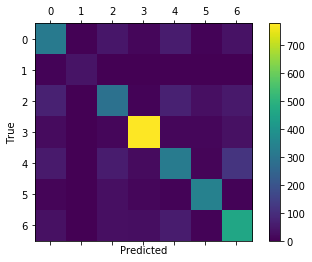

In [ ]:
#from sklearn.metrics import accuracy_score, precision_score, precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix
#from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools

true_labels = answer
predicted_labels = preds

'''for i in range(len(true_labels)):
    true_labels[i] = emotion[true_labels[i]]
    predicted_labels[i] = emotion[predicted_labels[i]]'''

# now to get confusion matrix one can use the confusion_matrix
# utility provided by sklearn
conf_mat = confusion_matrix(true_labels, predicted_labels)

# now it's time to plot the matrix
# some standard matplotlib code
# add a subplot
fig = plt.figure()
ax = fig.add_subplot(111)

# plot the matrix
cax = ax.matshow(conf_mat)

# add colorbar for reference
fig.colorbar(cax)

# add labels to plot
plt.xlabel("Predicted")
plt.ylabel("True")
#plt.savefig("Conf_Mat.jpg")
plt.show()



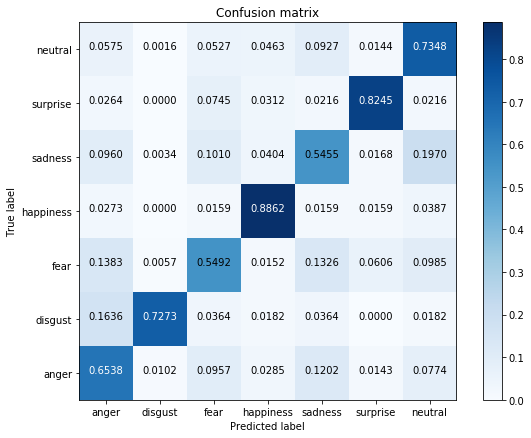

In [ ]:
conf_mat_norm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

def plot_confusion_matrix(cm, target_names=emotion, cmap=None, normalize=True, labels=True, title='Confusion matrix'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    plt.ylim((-0.5,6.5))

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)

    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    #plt.savefig("Conf_Mat.jpg")
    plt.show()

plot_confusion_matrix(conf_mat_norm)

In [ ]:
print("Classificcation Report: \n{}".format(classification_report(true_labels, predicted_labels)))

Classificcation Report: 
              precision    recall  f1-score   support

           0       0.60      0.65      0.63       491
           1       0.78      0.73      0.75        55
           2       0.61      0.55      0.58       528
           3       0.90      0.89      0.89       879
           4       0.60      0.55      0.57       594
           5       0.83      0.82      0.83       416
           6       0.65      0.73      0.69       626

    accuracy                           0.71      3589
   macro avg       0.71      0.70      0.71      3589
weighted avg       0.71      0.71      0.71      3589

